In [1]:
from keras.models import Sequential
from keras.models import Model
from keras.models import load_model
from keras.layers import Input,Dense,Concatenate, BatchNormalization

from keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import classification_report
from keras import backend as K
import numpy as np
import pandas as pd

In [2]:
from tensorflow import keras

In [3]:
!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [4]:
#np.random.seed(0)

In [5]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
#2. Get the file

downloaded = drive.CreateFile({'id':"10p5txVQSGSZnMPXDiiSCOdyVBB_Qf5Wf"})   # replace the id with id of file you want to access
downloaded.GetContentFile('bneural.npy')

In [7]:
#2. Get the file
#https://drive.google.com/file/d/14t8vfcV1lPoNs6mCs8krMc04weFZgF0o/view?usp=sharing
downloaded = drive.CreateFile({'id':"14t8vfcV1lPoNs6mCs8krMc04weFZgF0o"})   # replace the id with id of file you want to access
downloaded.GetContentFile('bsentences.csv')

In [8]:
#2. Get the file
#https://drive.google.com/file/d/1A5DvzbT_kFADOTTr2GNVLAjzGkItQPti/view?usp=sharing
downloaded = drive.CreateFile({'id':"1A5DvzbT_kFADOTTr2GNVLAjzGkItQPti"})   # replace the id with id of file you want to access
downloaded.GetContentFile('bexternal.npy')

In [9]:
sentences = pd.read_csv('bsentences.csv')
sentences = sentences[['label']]
sentences = np.array(sentences.values.tolist())
np.random.shuffle(sentences)
train_Y = sentences[:6000] 
test_Y = sentences[6000:]



In [10]:
bexternal = np.load('bexternal.npy')
#np.random.shuffle(bexternal)
train_bexternal = bexternal[:6000]
test_bexternal = bexternal[6000:]
del bexternal

In [11]:
bneural = np.load('bneural.npy')
#np.random.shuffle(bneural)
train_neural = bneural[:6000]
test_neural = bneural[6000:]
del bneural

In [12]:
#2. Get the file
#https://drive.google.com/file/d/1A5DvzbT_kFADOTTr2GNVLAjzGkItQPti/view?usp=sharing
downloaded = drive.CreateFile({'id':"1oC1u_4ZazEfSSC8Zt9A60ISvrdjoUQa1"})   # replace the id with id of file you want to access
downloaded.GetContentFile('idf.npy')

In [13]:
#2. Get the file
#https://drive.google.com/file/d/1A5DvzbT_kFADOTTr2GNVLAjzGkItQPti/view?usp=sharing
downloaded = drive.CreateFile({'id':"1M8Bo6XyM_ClFqB3oNcllXTEFTFGfUTbA"})   # replace the id with id of file you want to access
downloaded.GetContentFile('tf.npy')

In [14]:
#2. Get the file
#https://drive.google.com/file/d/1A5DvzbT_kFADOTTr2GNVLAjzGkItQPti/view?usp=sharing
downloaded = drive.CreateFile({'id':"1lNXnrRY13kClM25Wz-rROTZYm4RJWBS5"})   # replace the id with id of file you want to access
downloaded.GetContentFile('stat_head.npy')

In [15]:
tf = np.load('tf.npy')
idf = np.load('idf.npy')
stat_head = np.load('stat_head.npy')
stat_body = np.multiply(tf,idf)
del tf
del idf
bstat = np.concatenate((stat_head,stat_body),axis=1)
del stat_head
del stat_body
#np.random.shuffle(bstat)
train_bstat = bstat[:6000]
test_bstat = bstat[6000:]
del bstat

In [16]:
def to_categorical(sequences):
    cat_sequences = []
    for s in sequences:
      for item in s:
          #print(item)
          cats = np.zeros(2,dtype=float)
          cats[int(item)] = 1.0
        #for item in s:
            
            
          cat_sequences.append(cats)
    return np.array(cat_sequences)

In [17]:
#test_Y = to_categorical(test_Y)

In [18]:
train_bexternal.shape

(6000, 21)

In [19]:
test_bexternal.shape

(1202, 21)

In [20]:
train_neural.shape

(6000, 512)

In [21]:
test_neural.shape

(1202, 512)

In [22]:
train_bstat.shape

(6000, 129315)

In [23]:
test_bstat.shape

(1202, 129315)

In [24]:
train_Y.shape

(6000, 1)

In [25]:
test_Y.shape

(1202, 1)

In [26]:
inputA = Input(shape=(512,))
inputB = Input(shape=(129315,))
inputC = Input(shape=(21,))
# the first branch operates on the first input
x = Dense(256, activation="relu")(inputA)
x = Dense(128, activation="sigmoid")(x)
x = Dense(32, activation="relu",kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = Dense(8, activation="sigmoid")(x)
x = Dense(2, activation="relu")(x)
x = Model(inputs=inputA, outputs=x)
# the second branch opreates on the second input
# y = Dense(, activation="relu")(inputB)
#y = Dense(8192, activation="relu")(inputB)
#y = Dense(4096, activation="relu")(inputB)
#y = Dense(1024, activation="sigmoid")(inputB)
y = Dense(256, activation="relu",kernel_regularizer=keras.regularizers.l2(0.001))(inputB)
y = Dense(64, activation="sigmoid")(y)
y = Dense(8, activation="relu")(y)
y = Dense(2, activation="sigmoid")(y)
y = Model(inputs=inputB, outputs=y)

z = Dense(8, activation = "sigmoid")(inputC)
z = Dense(2, activation = "relu",kernel_regularizer=keras.regularizers.l2(0.001))(z)
z = Model(inputs = inputC, outputs = z)
# combine the output of the three branches
combined = Concatenate()([x.output, z.output, y.output])
#print(combined.shape)
# apply a FC layer and then a regression prediction on the
# combined outputs
z1 = BatchNormalization()(combined)
#z = Dense(2, activation="relu")(combined)
z1 = Dense(2, activation="softmax")(z1)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, z.input, y.input], outputs=z1)

In [27]:
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          131328      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 129315)]     0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       dense[0][0]                      
_______________________________________________________________________________________

In [28]:
model.compile(loss="categorical_crossentropy",optimizer=Adam(0.001),metrics=['accuracy'])


In [29]:
train_Y

array([[0.],
       [0.],
       [1.],
       ...,
       [1.],
       [0.],
       [1.]])

In [30]:
model.fit(x = [train_neural, train_bexternal, train_bstat], y = np.array(to_categorical(train_Y)),batch_size =16,epochs=4,validation_split=0.2)

Epoch 1/4
300/300 [==============================] - 3s 12ms/step - loss: 0.7391 - accuracy: 0.5406 - val_loss: 0.7211 - val_accuracy: 0.5717
Epoch 2/4
300/300 [==============================] - 3s 10ms/step - loss: 0.7440 - accuracy: 0.6273 - val_loss: 0.8366 - val_accuracy: 0.4667
Epoch 3/4
300/300 [==============================] - 3s 10ms/step - loss: 0.5395 - accuracy: 0.8123 - val_loss: 1.5246 - val_accuracy: 0.5717
Epoch 4/4
300/300 [==============================] - 3s 10ms/step - loss: 0.3941 - accuracy: 0.8783 - val_loss: 1.3344 - val_accuracy: 0.4642


In [31]:
def ret_tags(sequences):
    tags = []
    for sequence in sequences:
        temp = float(np.argmax(sequence))
        
        #temp.append(index[np.argmax(sequence)])
 
        tags.append(temp)
 
    return tags

In [32]:
# del train_bexternal
# del train_bstat
# del train_neural

In [33]:
scores = model.evaluate([test_neural,test_bexternal,test_bstat],to_categorical(test_Y) ) 

print(f"{model.metrics_names[1]}: {scores[1] * 100}")

38/38 [==============================] - 0s 8ms/step - loss: 1.3062 - accuracy: 0.4900
accuracy: 49.00166392326355


In [34]:
pred = model.predict([test_neural,test_bexternal,test_bstat])

In [35]:
pred

array([[0.44837835, 0.5516216 ],
       [0.05020016, 0.9497998 ],
       [0.5253592 , 0.47464082],
       ...,
       [0.09436712, 0.90563285],
       [0.0135587 , 0.9864413 ],
       [0.78624755, 0.21375242]], dtype=float32)

In [36]:
predictions = ret_tags(pred)

In [37]:
predictions

[1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0

In [38]:
targets = []
for item in test_Y:
  for i in item:
    targets.append(i)

In [39]:
targets

[1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0

In [40]:
from sklearn.metrics import classification_report
print(classification_report(targets,predictions))

              precision    recall  f1-score   support

         0.0       0.46      0.62      0.53       548
         1.0       0.55      0.38      0.45       654

    accuracy                           0.49      1202
   macro avg       0.50      0.50      0.49      1202
weighted avg       0.50      0.49      0.48      1202



In [41]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(targets,predictions)

In [42]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

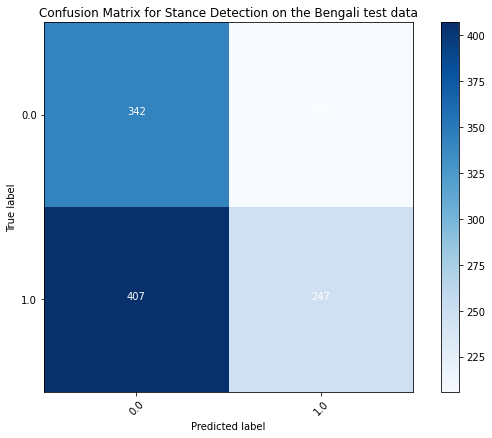

In [43]:
plot_confusion_matrix(cm,normalize=False,target_names = [0.0,1.0],title='Confusion Matrix for Stance Detection on the Bengali test data')